In [1]:
from __future__ import print_function
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline
"""
plt.rcParams['figure.figsize'] = (32.0, 32.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

"""

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f,encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
    return X, Y
def load_CIFAR10(dir):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join('datasets', dir, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join('datasets', dir, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def distance(X_test, X_train):
    """
    输入:
    X_test -- 由numpy数组表示的测试集，大小为(d , num_test)
    X_train -- 由numpy数组表示的训练集，大小为(d, num_train)
    输出:
    distances -- 测试数据与各个训练数据之间的距离,大小为(num_test, num_train)的numpy数组
    """
    num_test = X_test.shape[1]
    num_train = X_train.shape[1]
    distances = np.zeros((num_test, num_train)) # test和train对应的数组
    # (X_test - X_train)*(X_test - X_train) = -2X_test*X_train + X_test*X_test + X_train*X_train
    #展开平方差公式，是不是这样就可以使用numpy的并行计算？
    #print(X_test.shape,X_train.shape)
    
    dist1 = np.multiply(np.dot(X_test.T,X_train), -2)    # -2X_test*X_train, shape (num_test, num_train)
    dist2 = np.sum(np.square(X_test.T), axis=1, keepdims=True)    # X_test*X_test, shape (num_test, 1)
    dist3 = np.sum(np.square(X_train), axis=0,keepdims=True)    # X_train*X_train, shape(1, num_train)
    distances = np.sqrt(dist1 + dist2 + dist3)

    return distances

def predict(X_test, X_train, Y_train, k = [1]):
    """ 
    输入:
    X_test -- 由numpy数组表示的测试集，大小为(图片长度 * 图片高度 * 3 , 测试样本数)
    X_train -- 由numpy数组表示的训练集，大小为(图片长度 * 图片高度 * 3 , 训练样本数)
    Y_train -- 由numpy数组（向量）表示的训练标签，大小为 (1, 训练样本数)
    k -- 选取与训练集最近邻的数量的list
    输出:
    Y_prediction -- 包含X_test中所有预测值的numpy数组（向量）
    distances -- 由numpy数组表示的测试数据与各个训练数据之间的距离,大小为(测试样本数, 训练样本数)
    """
    
    distances = distance(X_test, X_train)
    
#     print(k)
    num_test = X_test.shape[1]
    Y_prediction = np.zeros((num_test,len(k)))
    for i in range(num_test):
        for j,item_k in enumerate(k):
            dists_min_k = np.argsort(distances[i])[:item_k]     # 按照距离递增次序进行排序,选取距离最小的k个点 
            y_labels_k = Y_train[0,dists_min_k]     # 确定前k个点的所在类别
            Y_prediction[i][j] = np.argmax(np.bincount(y_labels_k)) # 返回前k个点中出现频率最高的类别作为测试数据的预测分类

    
    
#     print(Y_prediction)
    return Y_prediction

def model(X_test, Y_test, X_train, Y_train, k = [1], print_correct = False):
    """
    输入：
    X_test -- 由numpy数组表示的测试集，大小为(图片长度 * 图片高度 * 3 , 测试样本数)
    X_train -- 由numpy数组表示的训练集，大小为(图片长度 * 图片高度 * 3 , 训练样本数)
    Y_train -- 由numpy数组（向量）表示的训练标签，大小为 (1, 训练样本数)
    Y_test -- 由numpy数组（向量）表示的测试标签，大小为 (1, 测试样本数)
    k -- 选取与训练集最近邻的数量的系列数组
    print_correct -- 设置为true时，打印正确率
    输出：
    d -- 包含模型信息的字典的数组
    """
    Y_prediction= predict(X_test, X_train, Y_train, k)
    num_correct = np.sum(Y_prediction == Y_test)
    d_array=[]
    for i,k_item in enumerate(k):
        accuracy = np.mean(Y_prediction[:,i] == Y_test)
        if print_correct:
            print('Correct %d/%d: The test accuracy: %f' % (num_correct, X_test.shape[1], accuracy))

        d_array.append({"k": k,
             "Y_prediction": Y_prediction, 
    #          "distances" : distances,
             "accuracy": accuracy})
    #print(d_array)
    #安装k数组里面的元素的顺序，排列成d
    return d_array


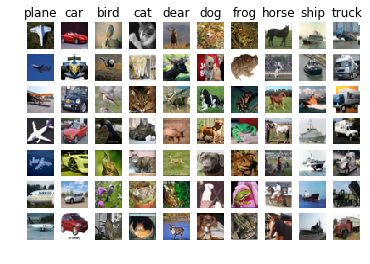

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = '/Users/apple/cifar-10-batches-py/cifar10-data'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)


classes = ['plane', 'car', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
num_each_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, num_each_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + (y + 1)
        plt.subplot(num_each_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


In [3]:
size_train = 5000
size_test = 1000
X_train = np.reshape(X_train, (X_train.shape[0], -1)).T # shape (d,50000)
X_test = np.reshape(X_test, (X_test.shape[0], -1)).T # shape (d,10000)

X_set_train = X_train[:,:size_train]     #shape (d , size_train)
X_set_test = X_test[:,:size_test]     #shape (d, size_test)
Y_set_train = y_train[:size_train].reshape(1,-1) # shape( 1, size_train)
Y_set_test = y_test[:size_test].reshape(1,-1)  # shape (1, size_test)



print(X_set_train.shape,X_set_test.shape,Y_set_train.shape,Y_set_test.shape)

(3072, 5000) (3072, 1000) (1, 5000) (1, 1000)


(3072, 5000)
(1, 5000)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


k = 1, fold = 1, accuracy: 0.263000
k = 1, fold = 2, accuracy: 0.257000
k = 1, fold = 3, accuracy: 0.264000
k = 1, fold = 4, accuracy: 0.278000
k = 1, fold = 5, accuracy: 0.266000
k = 3, fold = 1, accuracy: 0.239000
k = 3, fold = 2, accuracy: 0.249000
k = 3, fold = 3, accuracy: 0.240000
k = 3, fold = 4, accuracy: 0.266000
k = 3, fold = 5, accuracy: 0.254000
k = 5, fold = 1, accuracy: 0.248000
k = 5, fold = 2, accuracy: 0.266000
k = 5, fold = 3, accuracy: 0.280000
k = 5, fold = 4, accuracy: 0.292000
k = 5, fold = 5, accuracy: 0.280000
k = 8, fold = 1, accuracy: 0.262000
k = 8, fold = 2, accuracy: 0.282000
k = 8, fold = 3, accuracy: 0.273000
k = 8, fold = 4, accuracy: 0.290000
k = 8, fold = 5, accuracy: 0.273000
k = 10, fold = 1, accuracy: 0.265000
k = 10, fold = 2, accuracy: 0.296000
k = 10, fold = 3, accuracy: 0.276000
k = 10, fold = 4, accuracy: 0.284000
k = 10, fold = 5, accuracy: 0.280000
k = 12, fold = 1, accuracy: 0.260000
k = 12, fold = 2, accuracy: 0.295000
k = 12, fold = 3, acc

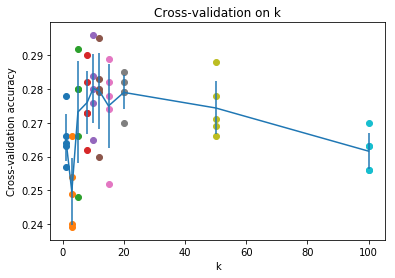

In [4]:
#train and test

k = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]    # all k, determine the best k

# models = {}
# accuracys = []

# models = model(X_set_test, Y_set_test, X_set_train, Y_set_train, k, print_correct = False)

# for i in range(len(k)):
#     #print(models[i])
#     # k.append(models[str(i)]["k"])
#     accuracys.append(models[i]["accuracy"])

# plt.plot(k, accuracys)
# plt.ylabel('accuracy')
# plt.xlabel('k')
# plt.show()


#cross validation
num_folds = 5    # split the training dataset to 5 parts

print(X_set_train.shape)
print(Y_set_train.shape)
# Split up the training data into folds
X_train_folds = []
Y_train_folds = []
X_train_folds = np.split(X_set_train.T, num_folds)
Y_train_folds = np.split(Y_set_train.T, num_folds)

# A dictionary holding the accuracies for different values of k
k_accuracy = {}

tmp_accuracy=np.zeros((len(k),num_folds))

accuracies=[]

for i in range(num_folds):
    
    X_cut_train = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:]).T
    Y_cut_train = np.concatenate(Y_train_folds[:i] + Y_train_folds[i+1:]).T
    X_cross_validation = X_train_folds[i].T
    Y_cross_validation = Y_train_folds[i].T

    ycv_model = model(X_cross_validation,Y_cross_validation,X_cut_train,Y_cut_train,k,print_correct = False)
    for j,k_item in enumerate(k):   
        tmp_accuracy[j][i]=ycv_model[j]["accuracy"]
    #print(tmp_accuracy)

for i,k_item in enumerate(k):
    k_accuracy[k_item]=tmp_accuracy[i]



# Print the accuracy
for k_item in k:
    for i in range(num_folds):
        print('k = %d, fold = %d, accuracy: %f' % (k_item, i+1, k_accuracy[k_item][i]))
        
for k_item in k:
    plt.scatter([k_item] * num_folds, k_accuracy[k_item]) # [k_item]数组乘以常数num_folds变成一个以为数组
    
# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = [np.mean(k_accuracy[k_item]) for k_item in k_accuracy] #计算每一个k值对应的平均值
accuracies_std = [np.std(k_accuracy[k_item]) for k_item in k_accuracy]   #对应每一个k值对应的标准差
plt.errorbar(k, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function

